# Accessing and Processing the Optical Absorption and Attenuation (OPTAA) Data from the Coastal Surface Piercing Profiler (CSPP)

This example uses data from the [OOI Gold Copy THREDDS catalog](https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/catalog.html) to demonstrate the steps a user would use to access and process the [Sea-Bird Scientific AC-S](https://www.seabird.com/ac-s-spectral-absorption-and-attenuation-sensor/product?id=60762467715) (known as the OPTAA in OOI-speak) from one of the [coastal surface-piercing profilers (CSPP)](https://oceanobservatories.org/marine-technologies/profilers/) employed by the [OOI Coastal Endurance Array](https://oceanobservatories.org/array/coastal-endurance/). 

The benefit to using the Gold Copy THREDDS catalog, as opposed to the OOI M2M system is the speed of access to the data. In the M2M system, each and every user request for the data requires the system to collect, process and format the data prior to delivery. For complex data, or data that requires extensive processing, this time can be quite lengthy. With the Gold Copy THREDDS catalog, those requests have already been done for you and you can just start with downloading the data.

In [1]:
%matplotlib inline

# load the different libraries and modules needed for the analysis
import csv
import io
import numpy as np
import os
import pandas as pd
import re
import xarray as xr

from ooi_data_explorations.common import get_vocabulary, load_gc_thredds
from ooi_data_explorations.uncabled.process_optaa import optaa_cspp

from matplotlib import pyplot as plt

For this example, we'll look at the data from Deployment 15 of the Oregon Shelf Coastal Surface-Piercing Profiler (CSPP) using data from the OOI Gold Copy THREDDS catalog rather than requesting the data from OOINet. The user still needs to know some needed parameters to find the data, such as the site, node, sensor, method and stream name prior to downloading the data. With that knowledge the `load_gc_thredds` function can be used (with an optional regex tag) to download the data.

In [2]:
%%time
# Setup needed parameters for the request
site = 'CE02SHSP'           # OOI site designator
node = 'SP001'              # OOI node designator
sensor = '04-OPTAAJ000'     # OOI sensor designator
method = 'recovered_cspp'   # OOI data delivery method
stream = 'optaa_dj_cspp_instrument_recovered'  # OOI stream name
level = 'cspp'              # local directory name, level below site
instrmt = 'optaa'           # local directory name, instrument below level
vocab = get_vocabulary(site, node, sensor)[0]

# We are after the the data from deployment 3
deploy = 15

# load data from the Gold Copy THREDDS catalog
optaa = load_gc_thredds(site, node, sensor, method, stream, ('deployment%04d.*OPTAA.*\\.nc$' % deploy))

# set up the calibration file path and name
cal_path = os.path.join(os.path.expanduser('~'), 'ooidata/m2m', site.lower(), level, instrmt)
cal_path = os.path.abspath(cal_path)
if not os.path.exists(cal_path):
    os.makedirs(cal_path)

cal_file = ('{}.{}.{}.deploy{:02d}.cal_coeffs.json'.format(site.lower(), level, instrmt, deploy))
cal_file = os.path.join(cal_path, cal_file)

CPU times: user 1.35 s, sys: 335 ms, total: 1.69 s
Wall time: 1.98 s


In [3]:
# view the dataset as downloaded from OOI (with some minor modifications, e.g. switching dimensions from obs to time)
optaa

<xarray.Dataset>
Dimensions:                       (time: 55904, wavelength: 85)
Coordinates:
  * wavelength                    (wavelength) int32 0 1 2 3 4 ... 81 82 83 84
  * time                          (time) datetime64[ns] 2019-08-13T19:03:52.8...
Data variables: (12/27)
    external_temp_raw             (time) uint16 41014 41015 ... 38599 38592
    c_signal_counts               (time, wavelength) uint16 690 810 ... 3012
    deployment                    (time) int32 15 15 15 15 15 ... 15 15 15 15 15
    a_signal_counts               (time, wavelength) uint16 545 649 ... 6568
    lat                           (time) float64 44.64 44.64 ... 44.64 44.64
    int_ctd_pressure              (time) float64 76.29 76.29 ... 0.823 0.7473
    ...                            ...
    a_signal_dark_counts          (time) uint16 625 625 625 625 ... 645 645 645
    c_reference_counts            (time, wavelength) uint16 863 994 ... 8197
    a_reference_dark_counts       (time) uint16 472 472 472 472 ... 472 473 473
    suspect_timestamp             (time) int8 0 0 0 1 0 0 0 0 ... 0 0 0 0 1 0 0
    depth                         (time) float64 75.66 75.66 ... 0.8163 0.7412
    sea_water_temperature         (time) float64 7.72 7.72 7.719 ... 12.1 12.1
Attributes: (12/67)
    node:                               SP001
    comment:                            Data produced by the OOI M2M API and ...
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             optaa_dj_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_max:                 -124.3022
    geospatial_lon_units:               degrees_east
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down

You can just start working with the OOI OPTAA data as-is at this point. However, the OOI OPTAA data sets do not include data products from the intermediate optical absorption and beam attenuation processing steps, where:

- the data has been converted from the raw, but has not been corrected for the effects of temperature and salinity or scattering
- the data has been corrected for the effects of temperature and salinity, but the scattering correction has not been applied to the optical absorption data
- the optical absorption data has been corrected for effects of scattering (this example utilizes the baseline scatter correction method)

Instead the OOI OPTAA only has the raw data and the final, temperature, salinity and scatter corrected data. It is considered good practice to make the intermediate data products available to users, especially more advanced users wishing to assess different methods for the scatter corrections. Additionally, if corrections to the spectra are required, using offsets determined by pre-deployment calibrations, these intermediate data products will be needed.

The `process_optaa` module (with different processing functions based on the platform the AC-S was deployed on) has been set up to recalculate these intermediate products starting from the raw measurements. Additionally, the scattering correction has been switched to the simpler [Baseline Correction](https://ioccg.org/wp-content/uploads/2020/09/absorption_protocol_final-incl-cover_rev.pdf) method from the more complicated [modified proportional method](https://github.com/cwingard/ion-functions/blob/master/ion_functions/data/opt_functions.py#L508) employed by OOI. This simpler algorithm tends to be more robust across all deployments, but arguments can be made for trying different methods. With the reprocessed data, the option to try different scatter correction methods is now a much simpler process.

In order to create these intermediate data products, we first need to download the vendor calibration data for the instrument from the OOI Asset Management records accessible via the OOI M2M system. The `cal_file` variable created above will hold this data. The first time the calibration data is downloaded, this file will be created. After that, the code will reuse the already downloaded data. The calibration data is saved in a `JSON` formatted data file, making both human and machine readable.

In [4]:
%%time
# use the optaa_datalogger function for AC-S data from surface moorings
optaa = optaa_cspp(optaa, cal_file)

Creating and adding a profile variable to the data set ...
Smoothing and binning each profile into 25 cm depth bins: 100%|██████████| 58/58 [00:07<00:00,  8.01it/s]


Converting attenuation data ...: 100%|██████████| 16796/16796 [00:03<00:00, 5375.89it/s]


CPU times: user 7.19 s, sys: 557 ms, total: 7.75 s
Wall time: 14.6 s


## Save the data for future work

At this point the optaa record is at a point where it can be saved locally or used in further work looking across deployments or between sites. Some of the work one might want to do is a review of the data by comparing the instrument temperature records versus the co-located CTD data, by computing different parameters (chlorophyll concentration, POC, and absorption ratios) from the absorption and attenuation records and by reviewing the shape and magnitude of the aborption and attenuation spectra.

In [5]:
nc_file = ('{}.{}.{}.deploy03.reprocessed.nc'.format(site.lower(), level, instrmt))
nc_file = os.path.join(cal_path, nc_file)
optaa.to_netcdf(nc_file, mode='w', format='NETCDF4', engine='h5netcdf')

The CTD seawater temperature and the instrument internal temperature are inputs to the functions used to calculate the optical absorption and beam attenuation. The data from the external temperature sensor on the AC-S is not used in the processing. It is not as accurate as the CTD temperature sensor and it has a slower response rate, so it doesn't accurately represent conditions in the water column. There is still some value to it, just take it with a grain of salt.

That being said, there are a couple of things to note. The internal temperature and the external water temperature (from the CTD) should be close to each other near the start of the profile, diverging as the profiler rises through the water column. Also, the external temperature sensor, with some offset due to differences in accuracy, should approximate the shape of the CTD temperature sensor (taking into account the response rate differences).

The AC-S data can be used to create estimates of the chlorophyll and particulate organic carbon (POC) concentration. These can be compared to data from a co-located fluorometer to help validate the performance of the sensors.

In [6]:
# split the data into profiles using the profile variable added in the above processing
profiles = optaa.groupby('profile')
profile = profiles[27]

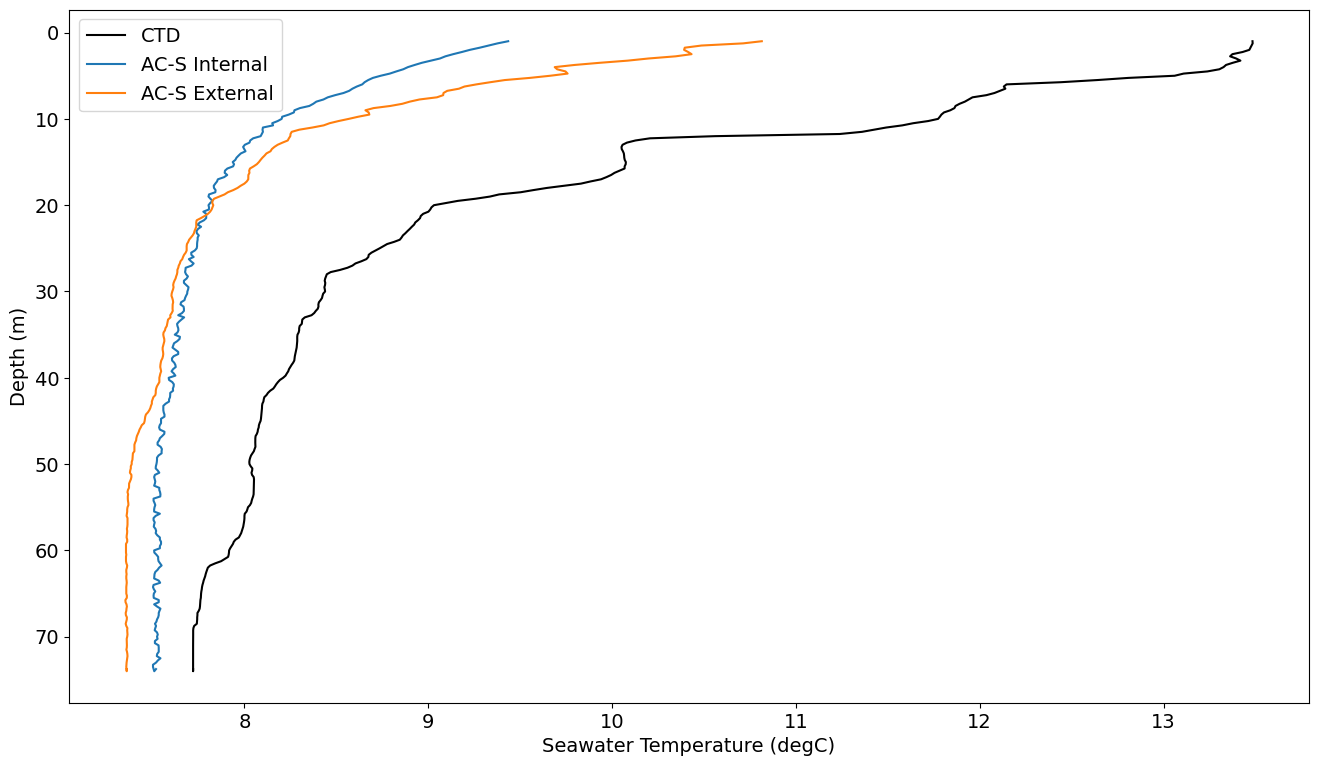

In [7]:
%matplotlib inline

# Plot the instrument and co-located CTD temperature records for profile 27
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))
plt.plot(profile['sea_water_temperature'], profile['depth'], '-k', label='CTD')
plt.plot(profile['internal_temp'], profile['depth'], label='AC-S Internal')
plt.plot(profile['external_temp'], profile['depth'], label='AC-S External')
plt.gca().invert_yaxis()
plt.xlabel('Seawater Temperature (degC)')
plt.ylabel('Depth (m)')
plt.legend()

In [8]:
%%time
import numpy as np
from ooi_data_explorations.uncabled.process_flort import flort_cspp

# Setup needed parameters for the request
sensor = '07-FLORTJ000'     # OOI Net sensor designator
stream = 'flort_sample'     # OOI Net stream name
method = 'recovered_cspp'   # OOI Net data delivery method
instrmt = 'flort'           # local directory name, instrument below level

# load data from the GC THREDDS Catalog
flort = load_gc_thredds(site, node, sensor, method, stream, ('deployment%04d.*FLORT.*\\.nc$' % deploy))
flort = flort_cspp(flort)

# create an estimate of POC from the particulate backscatter data
flort['estimated_poc'] = 53607 * (flort['bback'] - flort['sea_water_scattering_coefficient']) + 2.5  # derived from Cetinic et al., 2012 and references therein

# add the estimated chlorophyll and POC from the FLORT data to the AC-S data
chl = np.interp(optaa.time.astype(float), flort.time.astype(float), flort.estimated_chlorophyll)
poc = np.interp(optaa.time.astype(float), flort.time.astype(float), flort.estimated_poc)

optaa['fluorometric_chlorophyll'] = ('time', chl)
optaa['backscatter_poc'] = ('time', poc)
profiles = optaa.groupby('profile')
profile = profiles[27]

Creating and adding a profile variable to the data set ...
CPU times: user 1.33 s, sys: 27.9 ms, total: 1.36 s
Wall time: 1.6 s


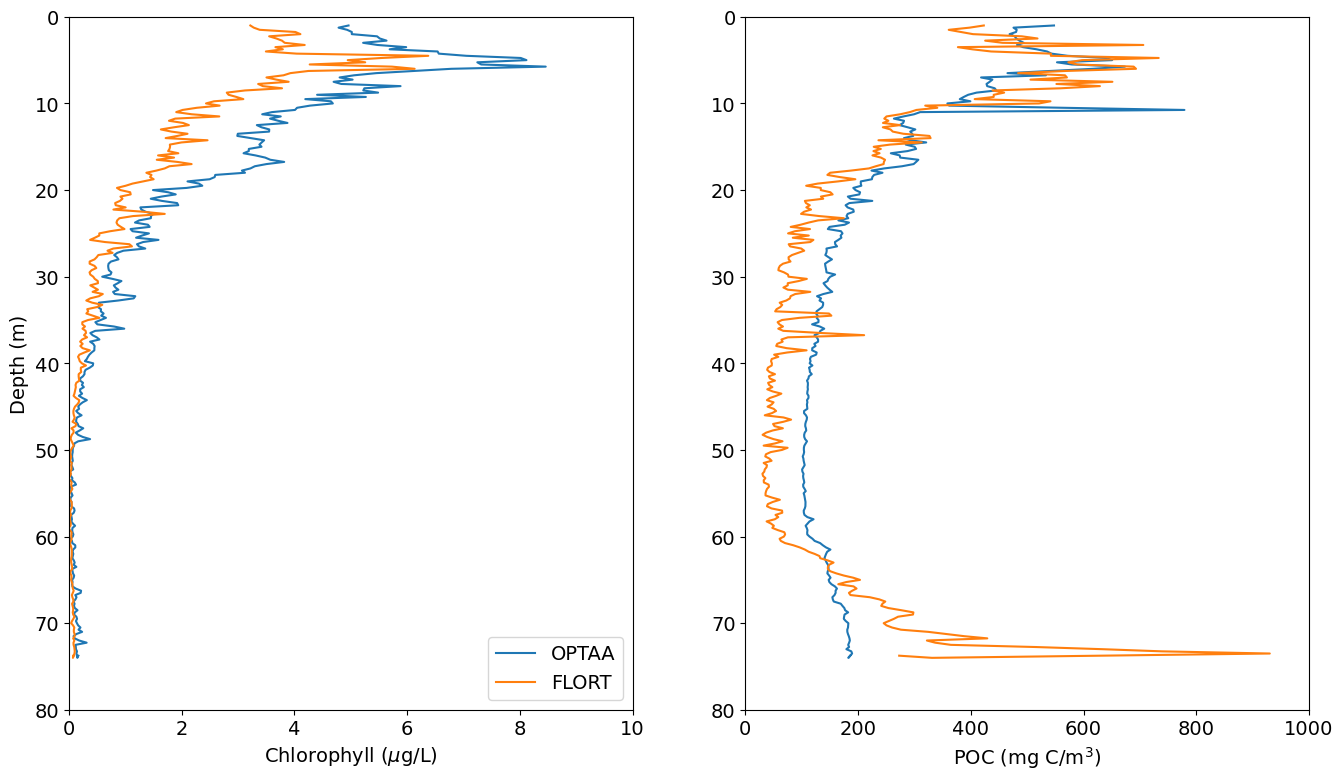

In [9]:
# plot the estimated chlorophyll and POC concentrations
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,9))

ax1 = plt.subplot(121)
plt.plot(profile['estimated_chlorophyll'], profile['depth'], label='OPTAA')
plt.plot(profile['fluorometric_chlorophyll'], profile['depth'], label='FLORT')
plt.xlabel('Chlorophyll ($\mu$g/L)')
plt.ylabel('Depth (m)')
plt.xlim([0, 10])
plt.ylim([0, 80])
plt.legend(loc='lower right')

ax2 = plt.subplot(122, sharey=ax1)
plt.plot(profile['estimated_poc'], profile['depth'])
plt.plot(profile['backscatter_poc'], profile['depth'])
plt.xlabel('POC (mg C/m$^3$)')
plt.xlim([0, 1000])
plt.ylim([0, 80])
plt.gca().invert_yaxis()
plt.show()

Finally, examining the shape and magnitudes of the absorption and attenuation spectra can be helpful in assessing the instrument performance in addition to revealing interesting information about the in situ absorption and attenuation properties of the seawater.

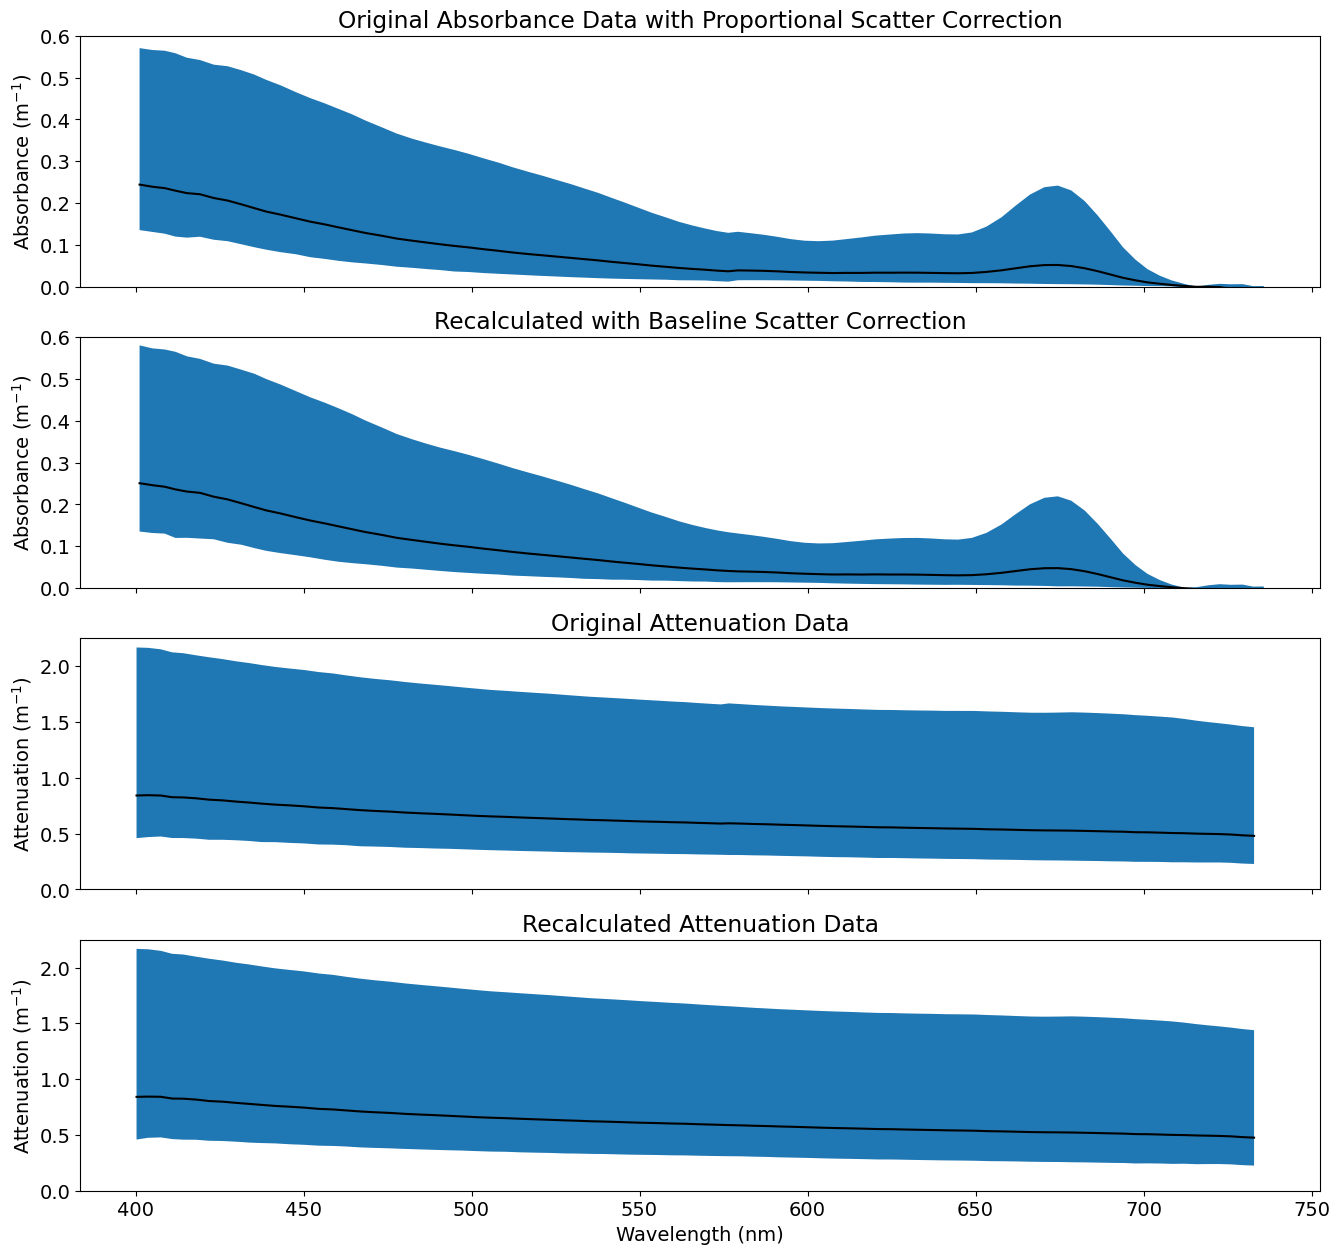

In [10]:
# plot the optical absortion and attenuation spectra (as calculated by OOI and as recalculated here)
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,15))

ax1 = plt.subplot(411)
plt.plot(profile['wavelength_a'][0, :], profile['optical_absorption'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_a'][0, :], profile['optical_absorption'].min(axis=0), 
                 profile['optical_absorption'].mean(axis=0) + profile['optical_absorption'].std(axis=0) * 3)
plt.ylim([0, 0.6])
plt.ylabel('Absorbance (m$^{-1}$)')
plt.title('Original Absorbance Data with Proportional Scatter Correction')
plt.setp(ax1.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax2 = plt.subplot(412, sharex=ax1)
plt.plot(profile['wavelength_a'][0, :], profile['apg_ts_s'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_a'][0, :], profile['apg_ts_s'].min(axis=0), 
                 profile['apg_ts_s'].mean(axis=0) + profile['apg_ts_s'].std(axis=0) * 3)
plt.ylim([0, 0.6])
plt.ylabel('Absorbance (m$^{-1}$)')
plt.title('Recalculated with Baseline Scatter Correction')
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax3 = plt.subplot(413, sharex=ax1)
plt.plot(profile['wavelength_c'][0, :], profile['beam_attenuation'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_c'][0, :], profile['beam_attenuation'].min(axis=0), 
                 profile['beam_attenuation'].mean(axis=0) + profile['beam_attenuation'].std(axis=0) * 3)
plt.ylim([0, 2.25])
plt.ylabel('Attenuation (m$^{-1}$)')
plt.title('Original Attenuation Data')
plt.setp(ax3.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax4 = plt.subplot(414, sharex=ax1)
plt.plot(profile['wavelength_c'][0, :], profile['cpg_ts'].mean(axis=0), '-k')
plt.fill_between(profile['wavelength_c'][0, :], profile['cpg_ts'].min(axis=0), 
                 profile['cpg_ts'].mean(axis=0) + profile['cpg_ts'].std(axis=0) * 3)
plt.ylim([0, 2.25])
plt.ylabel('Attenuation (m$^{-1}$)')
plt.xlabel('Wavelength (nm)')
plt.title('Recalculated Attenuation Data')

plt.show()

Based on the plots of the chlorophyll, POC and absorbance and attenuation spectra, this particular deployment is looking quite good. Beyond needing to account for the occasional spikes in the data due to particulate matter (a common hazard for bio-optical instruments), the spectra, estimated chlorohyll and POC concentrations all look quite reasonable. There are some different ways to look at the data, either per profile like above, or slicing out a particular depth interval. For example....

In [11]:
# create a slice at 10 m for the entire deployment
slice10 = optaa.where((optaa['depth'] >= 9.75) & (optaa['depth'] <= 10.25), drop=True)

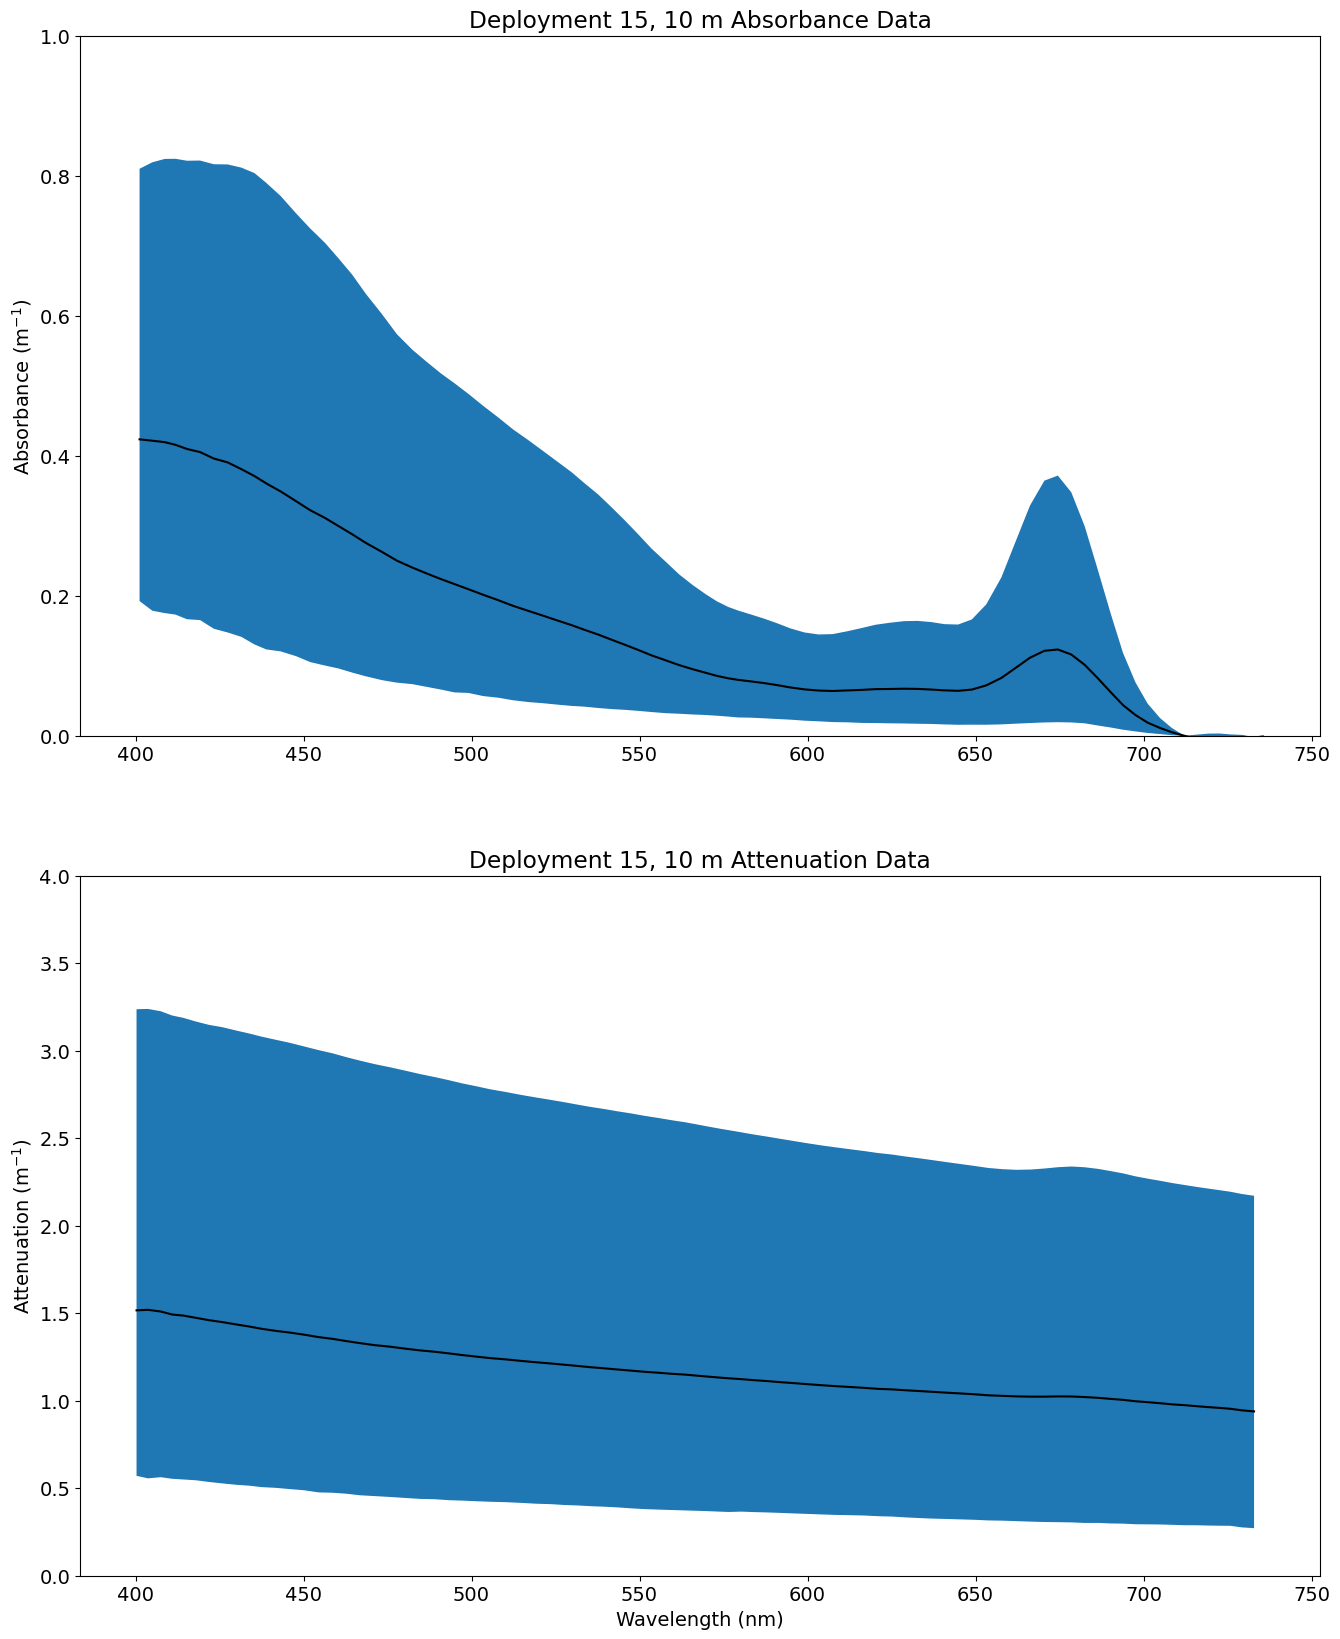

In [12]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,20))

ax1 = plt.subplot(211)
plt.plot(slice10['wavelength_a'][0, :], slice10['apg_ts_s'].mean(axis=0), '-k')
plt.fill_between(slice10['wavelength_a'][0, :], slice10['apg_ts_s'].min(axis=0), 
                 slice10['apg_ts_s'].mean(axis=0) + (slice10['apg_ts_s'].std(axis=0) * 3))
plt.ylim([0, 1])
plt.title('Deployment 15, 10 m Absorbance Data')
plt.ylabel('Absorbance (m$^{-1}$)')
plt.setp(ax2.get_xticklabels(), visible=False) # turn off x-axis ticklabels

ax2 = plt.subplot(212, sharex=ax1)
plt.plot(slice10['wavelength_c'][0, :], slice10['cpg_ts'].mean(axis=0), '-k')
plt.fill_between(slice10['wavelength_c'][0, :], slice10['cpg_ts'].min(axis=0), 
                 slice10['cpg_ts'].mean(axis=0) + (slice10['cpg_ts'].std(axis=0) * 3))
plt.ylim([0, 4])
plt.title('Deployment 15, 10 m Attenuation Data')
plt.ylabel('Attenuation (m$^{-1}$)')
plt.xlabel('Wavelength (nm)')
plt.show()